In [1]:
import numpy as np
from scipy.integrate import trapz
import matplotlib.pyplot as plt

# Define constants and parameters
X1 = 0
X2 = 2
Y1 = X2 + 0.01
Y2 = 30 + 0.01
n = int((X2 - X1) * 1000 + 1)
m = int((Y2 - Y1) * 100 + 1)
hx = (X2 - X1) / (n - 1)
hy = (Y2 - Y1) / (m - 1)
x = np.linspace(X1, X2, n)
y = np.linspace(Y1, Y2, m)

In [2]:
# Define functions f1, f2, f3, and f4
def f(x, M, G, F):
    return F**2 * ((M**4 + M**2 * G**2) / (24 * np.pi * ((x - M**2)**2 + M**2 * G**2)))


fV1, m1, gamma1 = 0.22, 0.78, 0.15
fV2, m2, gamma2 = 0.19, 1.46, 0.4
fV3, m3, gamma3 = 0.14, 1.72, 0.25
fV4, m4, gamma4 = 0.14, 1.90, 0.1

f1 = f(x, m1, gamma1, 1)
f2 = f(x, m2, gamma2, 1)
f3 = f(x, m3, gamma3, 1)
f4 = f(x, m4, gamma4, 1)

F = f1 + f2 + f3 + f4


In [3]:
# Calculate F1 and F2
F1 = f1
F2 = x - x

# Define parameters and error terms
B1, B2 = 1, 2
XD = 1.01
b1 = XD * B1
b2 = XD * B2

# Initialize arrays for G1, G2, G3
G1 = np.zeros((m,))
G2 = np.zeros((m,))
G3 = np.zeros((m,))

# Calculate G1
for i in range(m):
    G1[i] = trapz(1 / (y[i] - x) * F1, x)

# Calculate G2
for i in range(m):
    G2[i] = trapz(1 / (y[i] - x) * F2, x)

# Calculate f_exact and f_delta
f_exact = B1 * F1 + B2 * F2
f_delta = b1 * F1 + b2 * F2

# Calculate V_exact
MM = f_delta[0]
NN = f_delta[-1]
V_exact = (MM * (x - X2)) / (X1 - X2) + (NN * (x - X1)) / (X2 - X1)

# Calculate G3
for i in range(m):
    G3[i] = trapz(1 / (y[i] - x) * V_exact, x)


# Calculate g_exact and g_delta
g_exact = B1 * G1 + B2 * G2
g_delta = b1 * G1 + b2 * G2

# Calculate U_exact and G_exact and G_delta
U_exact = f_exact - V_exact
G_exact = g_exact - G3
G_delta = g_delta - G3


In [4]:
# Initialize matrices and vectors
Aphi = np.zeros((m, n))
A = np.zeros((n, n))
ba = np.zeros(n)


In [5]:
# Calculate Aphi
for j in range(1, n - 1):
    Aphi[:, j] = 1 / hx * ((y - x[j - 1]) * np.log(y - x[j - 1])
                           + (x[j - 1] - x[j]) + (y - x[j + 1]) *
                           np.log(y - x[j + 1])
                           - 2 * (y - x[j]) * np.log(y - x[j]) - (x[j] - x[j + 1]))

Aphi[:, 0] = np.log(y - x[0]) + 1 / hx * ((y - x[1]) * np.log(y - x[1])
                                          - (y - x[0]) * np.log(y - x[0]) - (x[0] - x[1]))
Aphi[:, -1] = -np.log(y - x[-1]) + 1 / hx * (-(y - x[-1]) * np.log(y - x[-1])
                                             + (y - x[-2]) * np.log(y - x[-2]) + (x[-2] - x[-1]))

In [6]:
# Calculate A matrix and ba vector
for i in range(n):
    for j in range(n):
        A[i, j] = trapz(Aphi[:, i] * Aphi[:, j], y)
    ba[i] = trapz(Aphi[:, i] * G_delta, y)


In [7]:
# Initialize matrices M and M1
M = np.zeros((n, n))
M[0, 0] = 4
M[0, 1] = 2

for i in range(1, n - 1):
    M[i, i] = 8
    M[i, i - 1] = 2
    M[i, i + 1] = 2

M[-1, -1] = 4
M[-1, -2] = 2

M = hx / 12 * M

M1 = np.zeros((n, n))
M1[0, 0] = 1
M1[0, 1] = -1

for i in range(1, n - 1):
    M1[i, i] = 2
    M1[i, i - 1] = -1
    M1[i, i + 1] = -1

M1[-1, -1] = 1
M1[-1, -2] = -1

M1 = 1 / hx * M1
H1 = M + M1

# Remove rows and columns corresponding to boundary conditions
A = np.delete(A, [0, n - 2], axis=0)
A = np.delete(A, [0, n - 2], axis=1)
ba = np.delete(ba, [0, n - 2])
H1 = np.delete(H1, [0, n - 2], axis=0)
H1 = np.delete(H1, [0, n - 2], axis=1)


In [8]:
# Initialize arrays and parameters for iterations
ite = 20
alpha = np.zeros(ite)
ua = np.zeros((n - 2, ite))
Ua = np.zeros((n, ite))
fa = np.zeros((n, ite))
res = np.zeros((ite,))
err = np.zeros((ite,))
L = np.zeros((ite,))
LH = np.zeros((ite,))


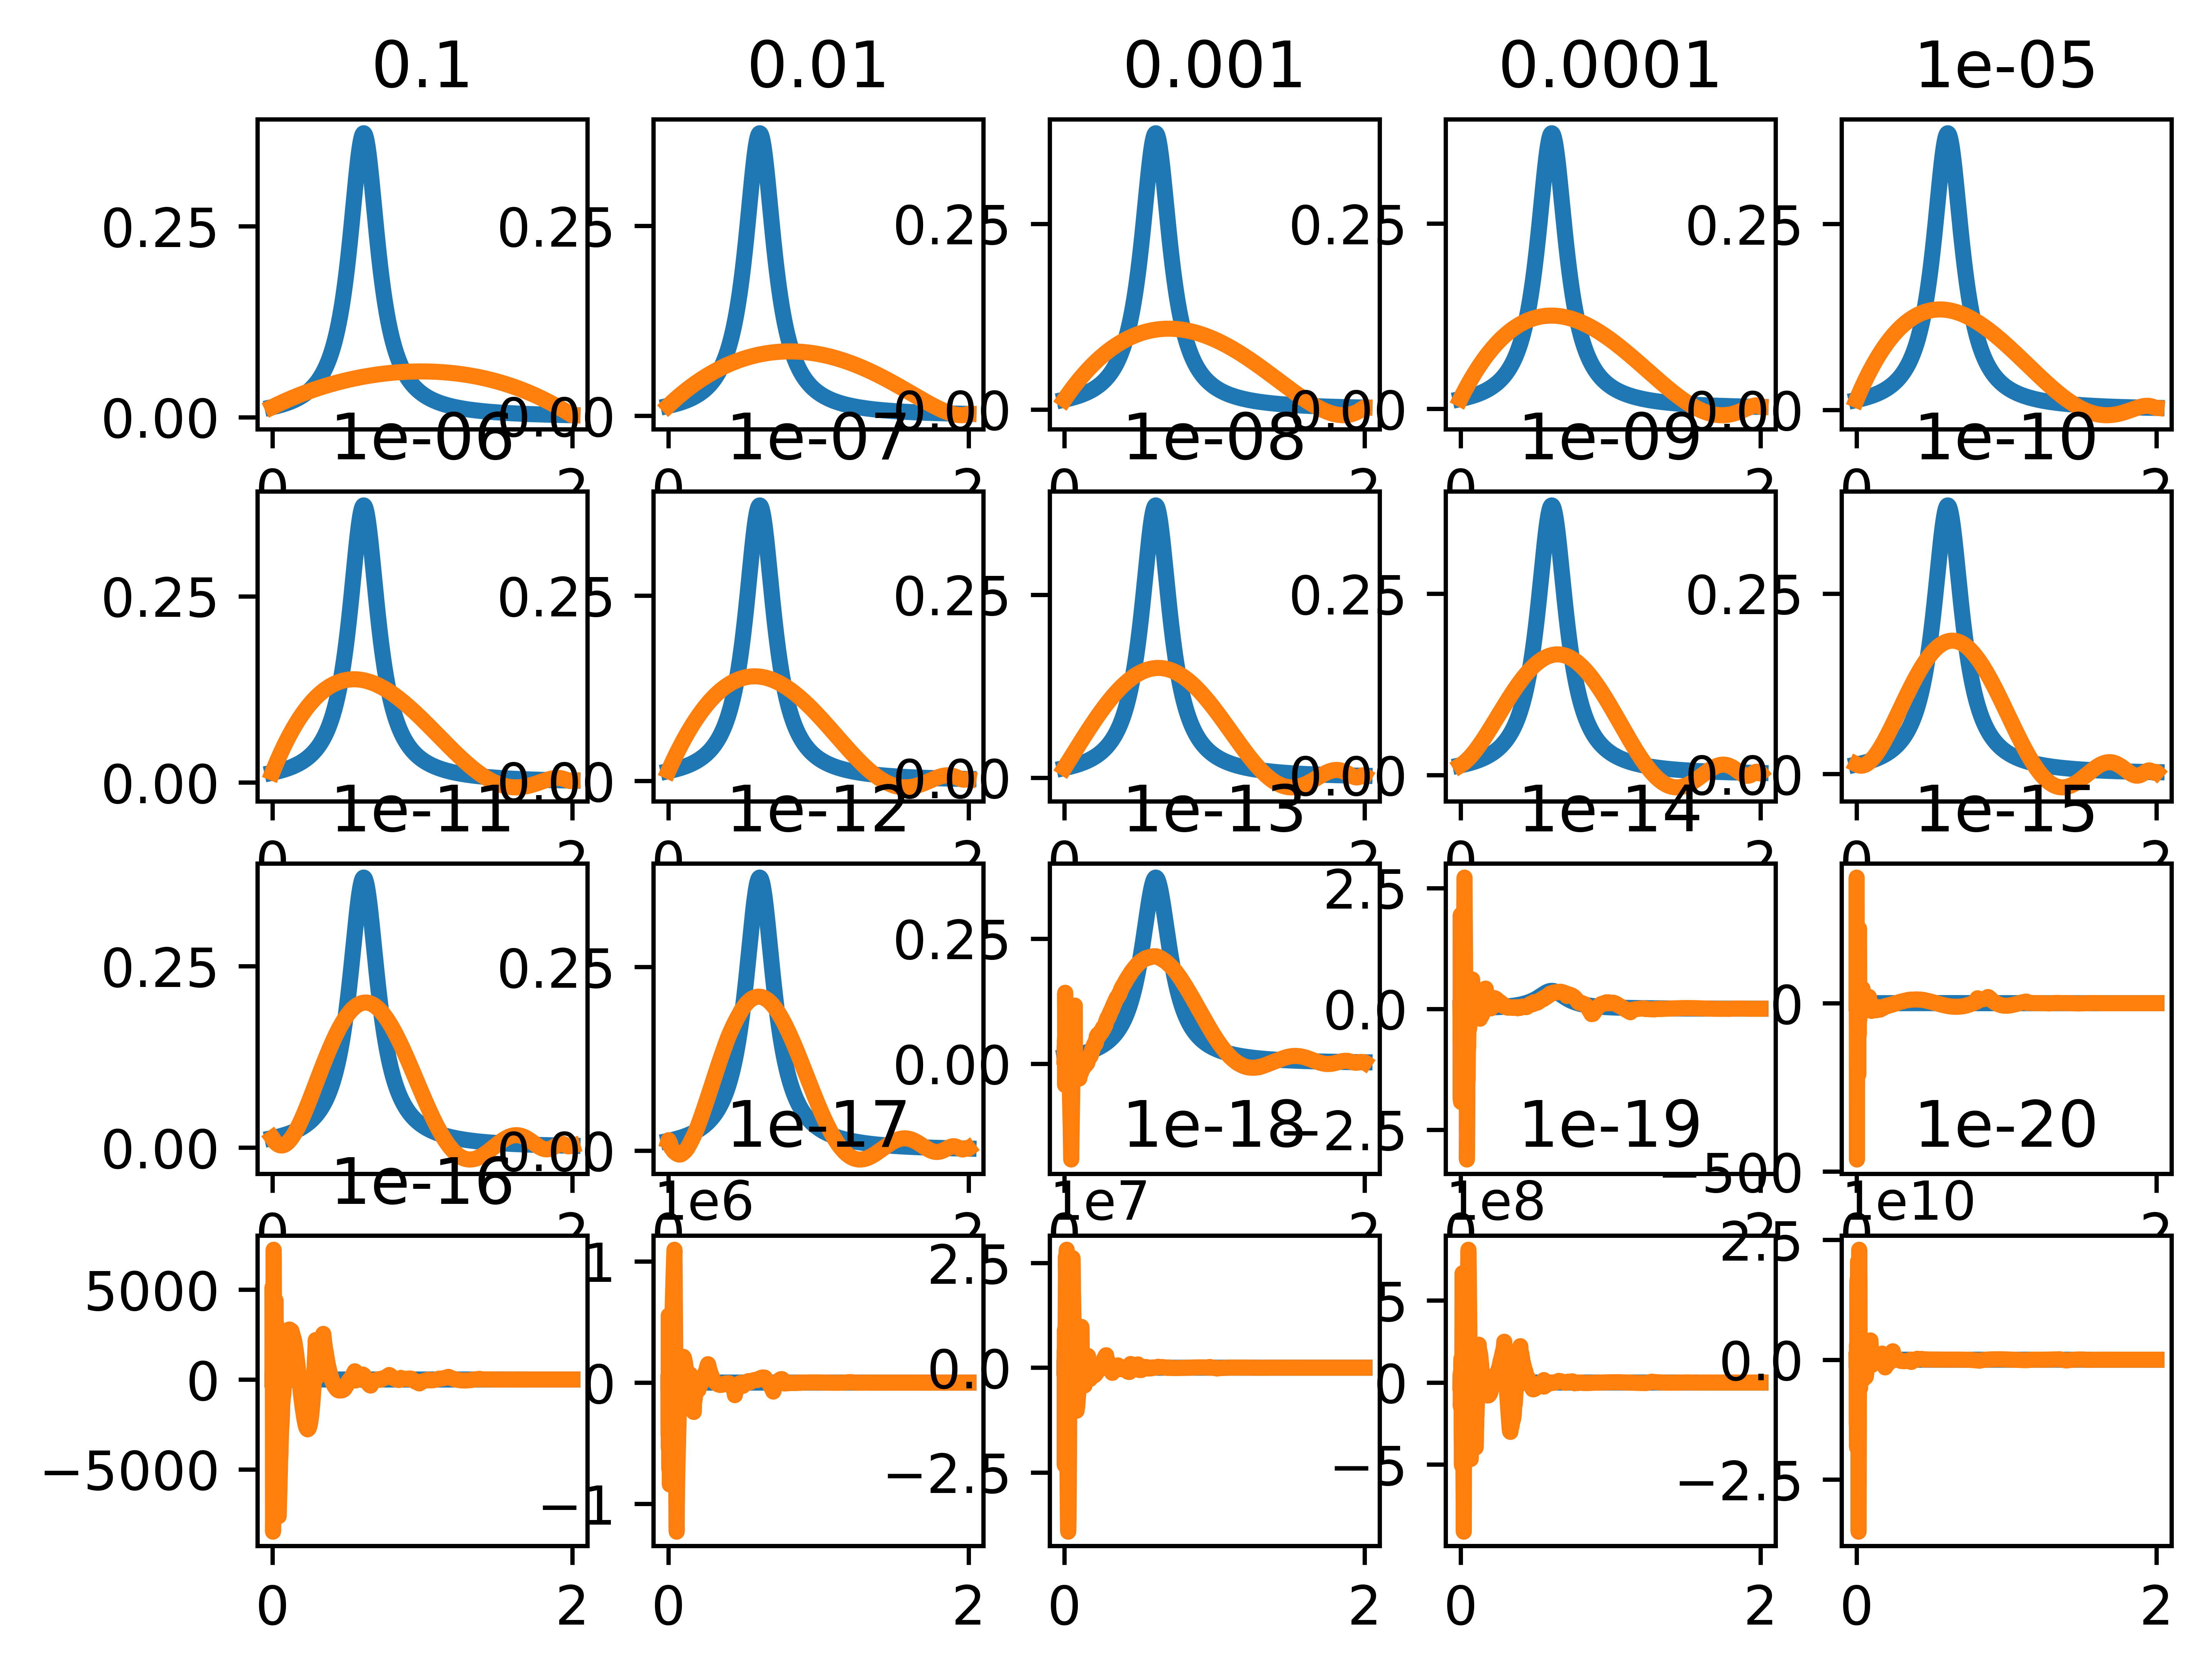

In [9]:
# Iterate to select regularization parameter
for k in range(ite):
    alpha[k] = 10**(-k-1)
    ua[:, k] = np.linalg.inv(A + alpha[k] * H1) @ ba  # very unstable
    Ua[:, k] = np.concatenate(([0], ua[:, k], [0]))
    fa[:, k] = Ua[:, k] + V_exact
    res[k] = np.sqrt(trapz((Aphi @ fa[:, k] - g_delta)**2, y))
    err[k] = np.sqrt(trapz((fa[:, k] - f_exact)**2, x))

    L[k] = np.sqrt(trapz(fa[:, k]**2, x)) * res[k]
    LH[k] = np.sqrt(
        trapz(fa[:, k]**2 + (np.gradient(fa[:, k]))**2, x)) * res[k]

    # Plot results
    plt.figure(1, dpi=1000)
    plt.subplot(4, 5, k + 1)
    plt.plot(x, f_exact, x, fa[:, k], linewidth=3)
    plt.title(str(alpha[k]))

# Show the plots
plt.show()


In [10]:
# Find indices of minimum values for L and LH criteria
kl = np.argmin(np.abs(L))
klh = np.argmin(np.abs(LH))

# Initialize arrays for V and Rho
V = np.zeros((ite, 1))
Rho = np.zeros((ite, 1))

In [11]:
# Calculate V and Rho
for i in range(ite):
    VV = np.eye(len(y)) - Aphi @ np.linalg.inv(Aphi.T @
                                               Aphi + alpha[i] * np.eye(len(x))) @ Aphi.T
    V1 = np.linalg.norm(VV @ g_delta)**2
    V2 = np.trace(VV)**2
    V[i] = V1 / V2

for i in range(ite):
    Rho[i] = np.linalg.norm(fa[:, i] / (alpha[i] *
                            (Aphi.T @ Aphi + alpha[i] * np.eye(len(x)))))


In [12]:
# Find indices of minimum values for V and Rho criteria
Vm = np.min(V)
Vi = np.argmin(V)
Rm = np.min(Rho)
Ri = np.argmin(Rho)

# Display results
results = [['L-curve+L^2', 'L-curve+H^1', 'GCV', 'Approx. Optimal'],
           [kl + 1, klh + 1, Vi + 1, Ri + 1]]  # Add 1 to indices to match MATLAB indexing

print(results)


[['L-curve+L^2', 'L-curve+H^1', 'GCV', 'Approx. Optimal'], [11, 11, 11, 1]]
